# 3rd Homework - Segmentation of e-shop customers (deadline November 29th 23:59)

An essential application of clustering is **customer segmentation**. 

Given transactional data of the form:

>TransactionID, CustomerID, Date (of the purchase), Subtotal (the price of the purchase)

we want to find segments of customers with similar behaviour. For this, we need to aggregate the transactions and have **one row as one customer**.

A popular framework to do that is **RFM**, which means:

- **R**ecency: Day since last purchase (last date in the data set - last purchase date set of a given customer)
- **F**requency: Number of purchases. Customers with only one purchase are sometimes excluded; let's leave them in the dataset for simplicity.
- **M**onetary: Total amount spent by the customer.

## Data source

Data about purchases of an (almost) fake e-shop are in the file `eshop.csv`.

## Instructions

Take the date of the last transaction (19. 12. 2015) as the actual date of the analysis - to simulate that the data is current.

**Basic points of the assignment (8 points)**:
  * Create an `rfm` data frame that has as many rows as customers, where each row is a customer, and the other columns are calculated as described above.
  * Use `k-means` for clustering. Find the optimal number of clusters (explain why you have chosen it).
  * Work with scaling and standardization of the data. Is it needed? Do it if yes.
  * Give an interpretation for the clusters. Can the clusters help you identify some superstar customers (high monetary, high frequency, low recency) from lousy ones (high recency, low frequency, low monetary)? Identify them.

**Further points of assignment**, for possible more points (you can choose, maximum for the homework is 12):
  * (up to 4 points) Use the method Silhouette to analyze the found clusters (https://en.wikipedia.org/wiki/Silhouette_(clustering)).
  * (up to 4 points) Do the clustering with a modified version of **RFM** where
    * Recency: a maximum of the number of months since the last purchase and number 1.
    * Frequency: a maximum of the number of purchases during last 12 months and number 1.
    * Monetary: the highest price of a single purchase of the given customer.
    
    Compare results with the original approach.

## Submission notes

  * Follow instructions at https://courses.fit.cvut.cz/BIE-VZD/homeworks/index.html
  * Submit Jupyter Notebook.
  * Reviewer may allow you to finish or correct your homework to achieve additional points. However, the first version is crucial.

In [65]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import silhouette_score

### Preparing the data

In [2]:
# 'Customer ID' is not working properly with df.itertuples()
df = pd.read_csv('eshop.csv', sep=',').rename(columns={'Customer ID':'Customer_ID'})
# Convert Date from object to datetime format
df['Date'] = pd.to_datetime(df['Date'])

In [3]:
df.info()
display(df)
print('\nNumber of NaN values in the columns:')
df.isnull().sum(axis=0)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22408 entries, 0 to 22407
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Customer_ID  22408 non-null  int64         
 1   Date         22408 non-null  datetime64[ns]
 2   Subtotal     22408 non-null  float64       
 3   Country      22405 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 700.4+ KB


,Customer_ID,Date,Subtotal,Country
0,34,2007-06-21,86.00,Czech Republic
1,38,2007-06-27,38.40,Czech Republic
2,47,2007-07-02,53.50,Slovakia
3,61,2007-07-14,7.00,Czech Republic
4,78,2007-07-21,55.50,Czech Republic
...,...,...,...,...
22403,15356,2015-12-18,31.87,Czech Republic
22404,15357,2015-12-18,6.10,Czech Republic
22405,15358,2015-12-18,153.23,Czech Republic
22406,15359,2015-12-19,19.15,Czech Republic



Number of NaN values in the columns:


Customer_ID    0
Date           0
Subtotal       0
Country        3
dtype: int64

In [4]:
display(df[df['Country'].isnull()])
display(pd.concat([df[df['Customer_ID'] == 965].head(2).reset_index(),
                   df[df['Customer_ID'] == 2934].head(2).reset_index(),
                   df[df['Customer_ID'] == 2612].head(2).reset_index()], axis=1))
# Here we can do, ether function to find a needed country by other orders of the same user_id,
# or as we see from the data we can just simply swap them by 'Czech Republic'

df['Country'] = df['Country'].fillna('Czech Republic')
print('\nCountry of order 6846 after fillna')
df['Country'].loc[[6846, 6856, 19145],]

,Customer_ID,Date,Subtotal,Country
6846,965,2011-10-24,50.35,NaN
6856,2934,2011-10-25,15.20,NaN
19145,2612,2015-02-06,37.19,NaN


,index,Customer_ID,Date,Subtotal,Country,index,Customer_ID,Date,Subtotal,Country,index,Customer_ID,Date,Subtotal,Country
0,395,965,2008-10-29,106.45,Czech Republic,2341,2934,2010-04-27,51.53,Czech Republic,1929,2612,2010-03-04,267.50,Czech Republic
1,1073,965,2009-09-09,65.20,Czech Republic,6856,2934,2011-10-25,15.20,NaN,2773,2612,2010-06-24,62.09,Czech Republic



Country of order 6846 after fillna


6846     Czech Republic
6856     Czech Republic
19145    Czech Republic
Name: Country, dtype: object

Ower first step is sorting by **R**ecency **F**requency **M**onetary 

In [5]:
# Grouping by CustomerID and aggregating
rfm = df.groupby(['Customer_ID']).agg({
        'Date': lambda x: (df['Date'].max() - x.max()).days,
        'Country': 'count',
        'Subtotal': 'sum'})

rfm = rfm.rename(columns={'Date':'Recency',
                    'Country':'Frequency',
                    'Subtotal':'Monetary'})

[2 1 1 ... 2 2 2]


Text(0.5, 0, 'Monetary')

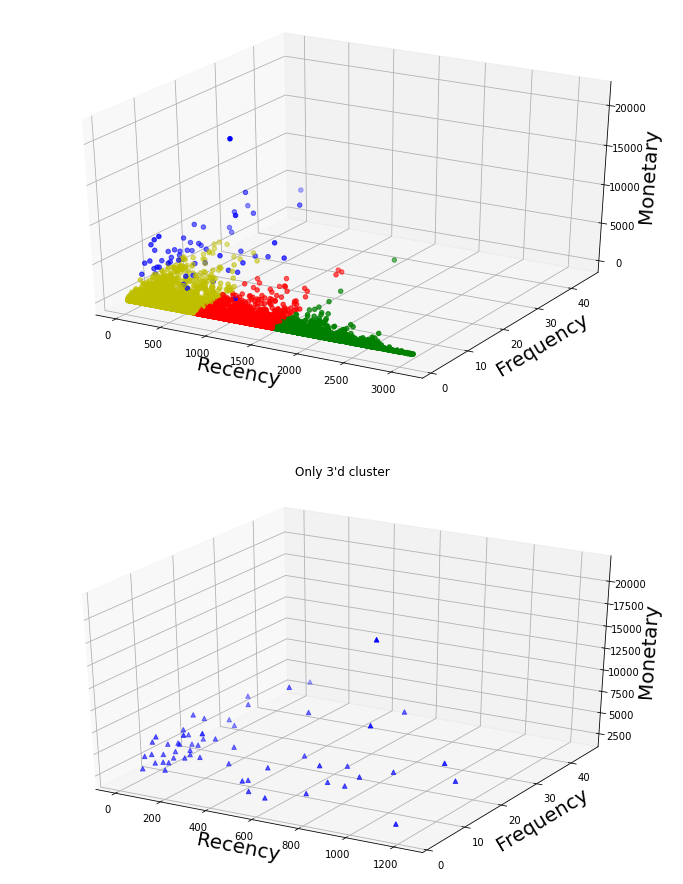

In [63]:
kmeans = KMeans(n_clusters=4, random_state=0).fit(rfm)
print(kmeans.labels_)
fig = plt.figure(figsize=(12, 16))
splt1 = fig.add_subplot(211, projection='3d')
splt1.scatter(rfm['Recency'], rfm['Frequency'], rfm['Monetary'],
           c=[{ 0 : 'r', 1 : 'g', 2 : 'y', 3 : 'b', 4 : 'c'}[i] for i in kmeans.labels_])
splt1.set_xlabel('Recency', fontsize=20)
splt1.set_ylabel('Frequency', fontsize=20)
splt1.set_zlabel('Monetary', fontsize=20)

# marker='^'
rfm_3cluster = rfm.reset_index()
mask = np.where(kmeans.labels_ == 3)
rfm_3cluster = rfm_3cluster.loc[mask[0],].set_index('Customer_ID')
splt2 = fig.add_subplot(212, projection='3d')
splt2.title.set_text('Only 3\'d cluster')
splt2.scatter(rfm_3cluster['Recency'], rfm_3cluster['Frequency'], rfm_3cluster['Monetary'],
           c='b', marker='^')
splt2.set_xlabel('Recency', fontsize=20)
splt2.set_ylabel('Frequency', fontsize=20)
splt2.set_zlabel('Monetary', fontsize=20)

From the visualization, we see that the blue cluster contains maybe the best customers, but this set is too small and seems just a segment of the yellow cluster. Thus possibly kmean with 3 clusters would be more useful. Lets validate it using Silhouette and Sum of Squared Errors and find optimal way.

Text(0, 0.5, 'Silhouette score')

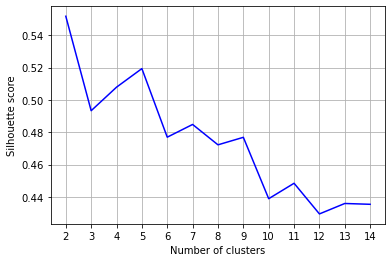

In [74]:
scores = []
for i in range(2, 15):
    kmeans = KMeans(n_clusters=i, random_state=0).fit(rfm)
    score = silhouette_score(rfm, kmeans.labels_)
    scores.append(score)

plt.plot( range(2, 15), scores, c='blue' )
plt.grid()
plt.xlabel('Number of clusters')
plt.xticks(np.arange(2, 15, step=1))
plt.ylabel('Silhouette score')

From chart we see that 4 cluster result possibly not the best one. Maybe dividing on 5 clusters give as needed "superstar customers" group.

[0 1 1 ... 0 0 0]


Text(0.5, 0, 'Monetary')

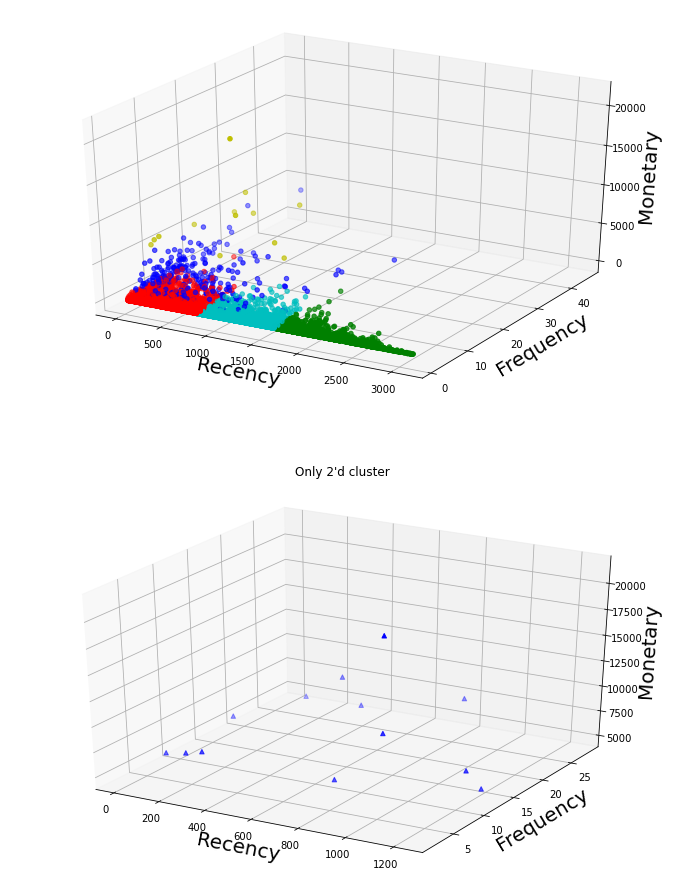

In [86]:
kmeans = KMeans(n_clusters=5, random_state=0).fit(rfm)
print(kmeans.labels_)
fig = plt.figure(figsize=(12, 16))
splt = fig.add_subplot(211, projection='3d')
splt.scatter(rfm['Recency'], rfm['Frequency'], rfm['Monetary'],
           c=[{ 0 : 'r', 1 : 'g', 2 : 'y', 3 : 'b', 4 : 'c'}[i] for i in kmeans.labels_])
splt.set_xlabel('Recency', fontsize=20)
splt.set_ylabel('Frequency', fontsize=20)
splt.set_zlabel('Monetary', fontsize=20)

rfm_2cluster = rfm.reset_index()
mask = np.where(kmeans.labels_ == 2)
rfm_2cluster = rfm_2cluster.loc[mask[0],].set_index('Customer_ID')
splt2 = fig.add_subplot(212, projection='3d')
splt2.title.set_text('Only 2\'d cluster')
splt2.scatter(rfm_2cluster['Recency'], rfm_2cluster['Frequency'], rfm_2cluster['Monetary'],
           c='b', marker='^')
splt2.set_xlabel('Recency', fontsize=20)
splt2.set_ylabel('Frequency', fontsize=20)
splt2.set_zlabel('Monetary', fontsize=20)

Now "super customer" group is 2'd clster 

# ================================================

In [75]:
rfm['R'] = pd.qcut(rfm['Recency'], q=3, labels=[3, 2, 1])
rfm['F'] = rfm['Frequency']/15  # we are dividing by 9 because rfm['Frequency'].max() == 45
rfm['F'] = rfm['F'].astype(int)

In [77]:
rfm[15:45]

,Recency,Frequency,Monetary,R,F
Customer_ID,,,,,
78,3073,1,55.50,1,0
79,3073,1,31.70,1,0
82,3069,1,110.80,1,0
87,2116,1,15.09,1,0
96,3042,1,63.60,1,0
98,2081,1,121.93,1,0
101,2298,2,108.65,1,0
115,411,7,904.48,3,0
129,2293,2,86.52,1,0


In [71]:
rfm['F'] = pd.cut(rfm['Frequency'].rank(method='max'), bins=5, labels=range(1, 6))
# rfm['F'] = rfm['Frequency']/9
# rfm['F'] = rfm['F'].astype(int)
    

# monetary = pd.qcut(rfm['Monetary'], q=5, labels=[1, 2, 3, 4, 5])

In [72]:
rfm[['Frequency', 'F']][30:50]

,Frequency,F
Customer_ID,,
171,1,1
182,1,1
188,2,3
190,1,1
192,1,1
213,1,1
216,19,5
218,1,1
226,1,1


In [73]:
rfm['F'].unique()

[4, 1, 3, 5]
Categories (4, int64): [1 < 3 < 4 < 5]

In [37]:
cust_df = pd.DataFrame(columns={'Customer_ID', 'Recency'})
for row in df.itertuples():
    display(row)
    break

Pandas(Index=22407, Customer_ID=15360, Date=Timestamp('2015-12-19 00:00:00'), Subtotal=139.1, Country='Czech Republic')

In [38]:
df.duplicated()

0        False
1        False
2        False
3        False
4        False
         ...  
22403    False
22404    False
22405    False
22406    False
22407    False
Length: 22408, dtype: bool